In [133]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from tqdm import tqdm 
import random

IMG_SIZE = 224

In [134]:
train = pd.read_csv('./Data/raw/train.csv')

# for stage 1 test purpose
train_s1 = train.loc[train['diagnosis'].isin({0, 4})].reset_index(drop=True)

(224, 224, 3)

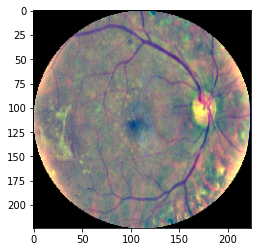

In [189]:
# TODO: Need Rewrite
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


# TODO: Need Rewrite
def circle_crop_v3(id):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(f'./Data/raw/train_images/{id}.png')
    img = crop_image_from_gray(img)    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), r/10), -4, 128)
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

plt.imshow(circle_crop_v3('001639a390f0'))
circle_crop_v3('001639a390f0').shape

In [192]:
train_X = []

# here, I only tested first three

for id in tqdm(train_s1.loc[:2, 'id_code']):
    train_X.append(circle_crop_v3(id))

train_X = np.asarray(train_X)

train_y = train_s1['diagnosis'].to_numpy()[:3]

train_X.shape, train_y.shape

100%|██████████| 3/3 [00:00<00:00, 11.31it/s]


((3, 224, 224, 3), (3,))

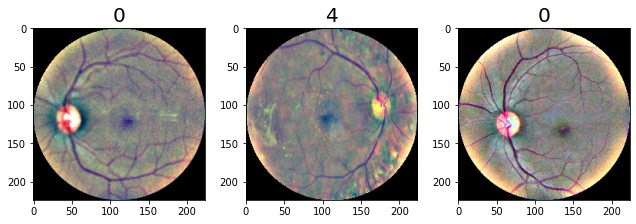

In [193]:
num_rows = 1
num_cols = 3
num_images = num_rows*num_cols
fig_size = 3
plt.figure(figsize=(fig_size*num_cols, fig_size*num_rows))
index_set = set()
for i in range(num_images):
    while True:
        index = random.randint(0, len(train_X)-1)
        if index in index_set:
            continue
        index_set.add(index)
        plt.subplot(num_rows, num_cols, i+1).set_title(train_y[index], fontsize=20)
        plt.imshow(train_X[index])
        break
plt.tight_layout()
plt.show()